# YOLO NAS Finetuning on custom dataset


## Necessary Setup and Imports

In [ ]:
# One time installation.
!pip install super-gradients==3.2.0


In [2]:
!pip install imutils

In [ ]:
!pip install wandb

In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

In [7]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import torch
import wandb

RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB

In [8]:
def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

# 🪡 Fine-tuning YOLONAS on custom dataset

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

- `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

- `experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

SuperGradients supports **Data Parallel** and **Distributed Data Parallel**.

That's outside of the scope for this introduction to SuperGradients. But, if you're fortunate enough to have multiple GPUs at your disposal or want learn more you can do so [here](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/device.md#3-dp---data-parallel).

In the code below, you'll instantiate the trainer with just a single GPU (since that's what Google Colab provides)

In [9]:
CHECKPOINT_DIR = 'checkpoints'

In [10]:
trainer = Trainer(experiment_name='large_model_run', ckpt_root_dir=CHECKPOINT_DIR)

## Download Dataset

In [11]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')

download_file(
    'https://app.roboflow.com/ds/Gi7A06UnbM?key=fl4u4rF4Eq',
    'defects.zip'
)

  0%|          | 0.00/66.2M [00:00<?, ?iB/s]

In [12]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('defects.zip')

Extracted all


In [13]:

!mkdir Defect_Data

In [14]:
%mv /content/test /content/train /content/valid /content/Defect_Data/

## Dataset Set Up

In [15]:
ROOT_DIR = '/content/Defect_Data/'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
test_imgs_dir = 'test/images'
test_labels_dir = 'test/labels'
classes = ['bridge', 'gap', 'sraf']

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [16]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes
}

You pass the values for `dataset_params` into the `dataset_params` argument as shown below.

You can also pass PyTorch DataLoaders arguments when instantiating your dataset. Here you'll set `batch_size=16` and `num_workers=2`.

Repeat this for the validation and testing datasets, note that for training and testing data we use `coco_detection_yolo_format_val` to instantiate the dataloader.

The dataloaders will print warnings when an annotation does not conform to the expected format.

In [17]:
# Global parameters.
EPOCHS = 50
BATCH_SIZE = 16
WORKERS = 2

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

## Visualize Ground Truth Images

In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=(26,26,139),
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=(26,26,139),
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

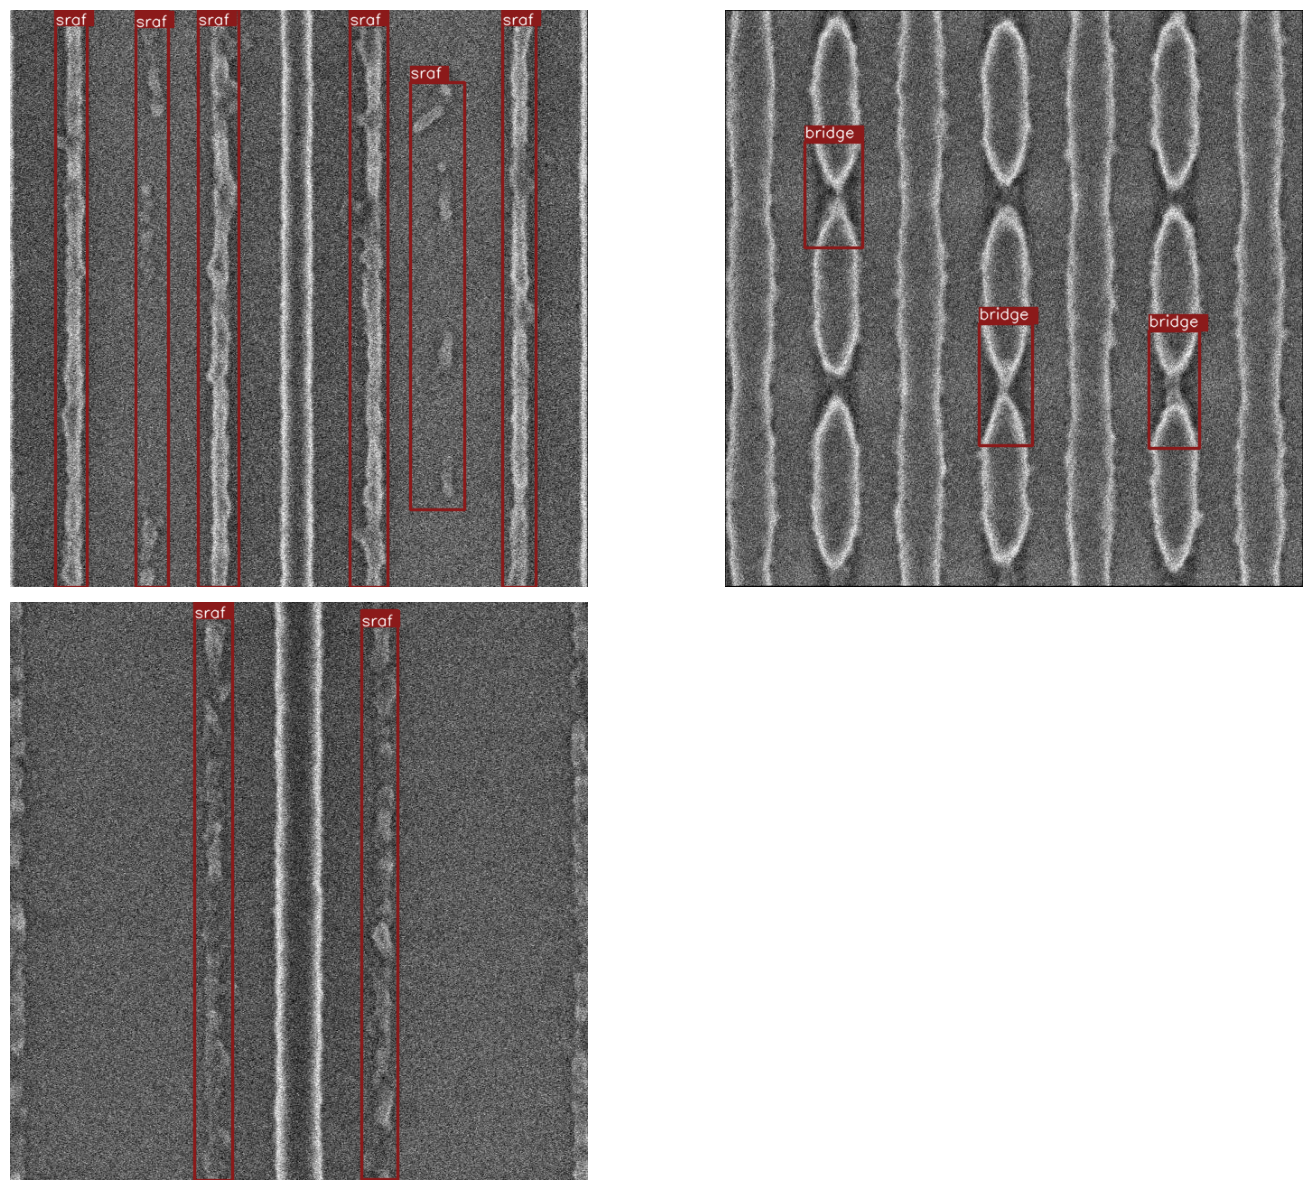

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, test_imgs_dir),
    label_path=os.path.join(ROOT_DIR, test_labels_dir),
    num_samples=3,
)

## Transforms a.k.a Augmentations


Now let's inspect the dataset defined earlier. SuperGradients added `transforms` for you. You're free to experiment with these transformations as you please. You can also add in your own transformations from `torchvision.transforms` or a custom tranformaton.

In [ ]:
train_data.dataset.transforms

You can either modify transforms in the following way:



```
train_data.dataset.transforms.pop(0) #just delete the transformation from the list
train_data.dataset.transforms[3].pad_value = 114 #change the particular value for single transformation

```

Another option: to redefine all the transforms as you want:
```
from super_gradients.training.transforms.transforms import DetectionRandomAffine, DetectionRGB2BGR, ...
transforms = [
DetectionRandomAffine(...)
]
```
To reproduce the same transorms, just go aver the [dataset params config file](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/dataset_params/coco_detection_yolo_nas_dataset_params.yaml) .
Note that some transforms are required since the model expects a very specific format (LABEL_CXCYWH padded for bbox, channel first for image)



In [ ]:
from super_gradients.training.transforms.transforms import DetectionHorizontalFlip

In [20]:
train_data.dataset.transforms.pop(1)

DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114)

In [21]:
train_data.dataset.transforms.pop(1)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [22]:
train_data.dataset.transforms[1].hgain = 0.015
train_data.dataset.transforms[1].sgain = 0.7
train_data.dataset.transforms[1].vgain = 0.4


In [23]:
train_data.dataset.transforms.pop(0)

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [24]:
train_data.dataset.transforms

[DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 0.015, 'sgain': 0.7, 'vgain': 0.4, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_formats.xyxy.XYXYCoordinateFormat object at 0x78765b7bfa90>), ('labels', name=labels length=1)]), 'output_format': OrderedDict([('labels', name=labels length=1), ('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_formats.cxcywh.CXCYWHCoordinateFormat object at 0x78765b84aa70>)]), 'min_bbox_edge_size': 1, 

You can plot a batch of training data with their augmentations applied to see what they look like:

In [ ]:
train_data.dataset.plot(plot_transformed_data=True)

# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, ClearML, and DagsHub.

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

In [25]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "SGD",
    "optimizer_params": {"weight_decay": 0.0005, "momentum": 0.937},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": False,
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16,
    ),
    "seed": 42,

    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            include_classwise_ap=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),

    ],
    "metric_to_watch": 'mAP@0.50',


    #define weights and biases logging
    "sg_logger": 'wandb_sg_logger',
    "sg_logger_params":
    {
        "project_name": "Yolo-NAS",
        "save_checkpoints_remote": True,
        "save_tensorboard_remote":True,
        'save_logs_remote':True,
        'entity':'ml_team_mskv'

    }
}

[2024-02-12 19:49:13] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class names, but we recommend to provide class names explicitly tohave meaningful names in reported metrics.


Below is how to instantiate the model for finetuning. Note you need to add the num_classes argument here.
Note, for this tutorial you're using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.



In [26]:
model_large = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-02-12 19:49:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:07<00:00, 35.3MB/s]
[2024-02-12 19:49:26] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


# 🦾 Training the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...


In [ ]:
trainer.train(model = model_large,
              training_params = train_params,
              train_loader = train_data,
              valid_loader = val_data)

# Evaluate the best model on the test set


Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_latest.pth`

In [29]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/yolo_nas_l.pth")
#"checkpoints/small_model_run/ckpt_best.pth"

[2024-02-13 10:26:06] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/yolo_nas_l.pth checkpoint.


In [31]:
mAP_50 = trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   include_classwise_ap=True,
                                                   class_names = classes,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  80%|████████  | 4/5 [03:38<00:53, 53.49s/it]

In [32]:
mAP_50_95 = trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050_095(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   include_classwise_ap=True,
                                                   class_names = classes,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  80%|████████  | 4/5 [04:05<00:59, 59.41s/it]

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [37]:
%cp /content/yolo_nas_l.pth /content/drive/MyDrive/models/

In [35]:
import pandas as pd


results = pd.DataFrame({
  'defect_type': ['sraf', 'bridge', 'gap', 'All'],
  'mAP_50': [mAP_50['AP@0.50_sraf'], mAP_50['AP@0.50_bridge'], mAP_50['AP@0.50_gap'], mAP_50['mAP@0.50']  ],
  'mAP_50_95': [mAP_50['AP@0.50_sraf'], mAP_50['AP@0.50_bridge'], mAP_50['AP@0.50_gap'],mAP_50_95['mAP@0.50:0.95'] ],
  'total_precision_50': [mAP_50['Precision@0.50']] * 4,
  'total_recall_50': [mAP_50['Recall@0.50']] * 4,
  'total_F1_score_50' : [mAP_50['F1@0.50']] * 4
})
results.to_csv('/content/drive/MyDrive/metrics/yolo_nas_l_datav6_val.csv')

# Make predictions with trained model

In [ ]:
best_model.predict('path/to/image', conf=0.25).show()

Now let's measure the FPS for the model:

In [ ]:
import time
start_time = time.time()
best_model.predict('/content/Defect_Data/test/images/', conf = 0.25)
end_time = time.time()

#total_fps = 1 / (end_time - start_time)
total_frames = len(os.listdir('/content/Defect_Data/test/images'))

average_fps =  total_frames / (end_time - start_time)
latency = (end_time - start_time) / total_frames
print(f'FPS: {average_fps:.3f} - denotes the number of images per second that can be processed by the model')
print(f'Latency:{latency:.3f} - denotes the amount of time taken to process one image ')

# Calculating standatd deviation for validation set

In [38]:
os.makedirs('/content/valid_folds/', exist_ok = True)

In [39]:
import shutil

file_types = ['images', 'labels']

def distribute_files(images_dir, labels_dir ,increment):
  cnt = 1
  img_files = sorted(os.listdir(images_dir))
  labels_files = sorted(os.listdir(labels_dir))
  for i in range(0, len(img_files), increment):
    fold_dir = '/content/valid_folds/' + f'fold_{cnt}'
    os.makedirs(fold_dir, exist_ok = True)

    image_type_dir = fold_dir +'/'+ file_types[0]
    os.makedirs(image_type_dir,  exist_ok = True)

    label_type_dir = fold_dir +'/'+ file_types[1]
    os.makedirs(label_type_dir,  exist_ok = True)

      #перемещам изображения
    for file in img_files[i:i + increment]:
      file_path = os.path.join(images_dir, file)
      shutil.copy(file_path, image_type_dir)

    for file in labels_files[i:i + increment]:
      file_path = os.path.join(labels_dir, file)
      shutil.copy(file_path, label_type_dir )
    cnt += 1


In [40]:
fold_number = 9
increment = len(os.listdir('/content/Defect_Data/valid/images')) // fold_number
increment

9

In [41]:
images_dir = '/content/Defect_Data/valid/images'
labels_dir = '/content/Defect_Data/valid/labels'


distribute_files(images_dir, labels_dir ,increment)

In [42]:
kfold_base_path='/content/valid_folds'

In [43]:
CHECKPOINT_DIR = 'std_checkpoints'
trainer = Trainer(experiment_name='calculate_std', ckpt_root_dir=CHECKPOINT_DIR)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
mAP_50_list = []

In [45]:
model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/yolo_nas_l.pth")

for i in range(1, fold_number + 2):

  fold_path = kfold_base_path + f'/fold_{i}'
  fold_img_path = fold_path + '/images'
  fold_label_path = fold_path + '/labels'

  #creating valid fold loader
  val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': fold_path,
        'images_dir': fold_img_path,
        'labels_dir': fold_label_path,
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    })


  fold_metrics = trainer.test(model=model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   include_classwise_ap=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))
  mAP_50_list.append(fold_metrics)

[2024-02-13 11:03:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/yolo_nas_l.pth checkpoint.
[2024-02-13 11:03:59] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 9/9 [00:00<00:00, 2174.97it/s]
[2024-02-13 11:03:59] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class names, but we recommend to provide class names explicitly tohave meaningful names in reported metrics.
Testing: 100%|██████████| 1/1 [00:26<00:00, 26.49s/it]
[2024-02-13 11:04:26] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 9/9 [00:00<00:00, 1266.14it/s]
[2024-02-13 11:04:26] WARNING - detectio

In [46]:
mAP_50_list[0]

{'Precision@0.50': 0.25827813148498535,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9400995373725891,
 'F1@0.50': 0.410526305437088,
 'AP@0.50_class_0': 0.0,
 'AP@0.50_class_1': 0.0,
 'AP@0.50_class_2': 0.9400995373725891}

In [47]:
mAP_50 = [mAP_50_list[i]['mAP@0.50'] for i in range(len(mAP_50_list)) ]

In [48]:
mAP_50

[0.9400995373725891,
 0.967634916305542,
 0.9679874181747437,
 0.9880145788192749,
 0.9489717483520508,
 0.9809118509292603,
 0.9943423271179199,
 0.904363751411438,
 0.7163119316101074,
 0.9434230327606201]

In [49]:
mAP_50_95_list = []

In [50]:
for i in range(1, fold_number + 2):

  fold_path = kfold_base_path + f'/fold_{i}'
  fold_img_path = fold_path + '/images'
  fold_label_path = fold_path + '/labels'

  #creating valid fold loader
  val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': fold_path,
        'images_dir': fold_img_path,
        'labels_dir': fold_label_path,
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    })


  fold_metrics = trainer.test(model=model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050_095(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   include_classwise_ap=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))
  mAP_50_95_list.append(fold_metrics)


[2024-02-13 11:11:02] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 9/9 [00:00<00:00, 2246.28it/s]
[2024-02-13 11:11:02] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class names, but we recommend to provide class names explicitly tohave meaningful names in reported metrics.
Testing: 100%|██████████| 1/1 [00:27<00:00, 27.78s/it]
[2024-02-13 11:11:30] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 9/9 [00:00<00:00, 1915.79it/s]
[2024-02-13 11:11:30] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class 

In [51]:
mAP_50_95_list[0]

{'Precision@0.50:0.95': 0.19006621837615967,
 'Recall@0.50:0.95': 0.735897421836853,
 'mAP@0.50:0.95': 0.6306675672531128,
 'F1@0.50:0.95': 0.30210527777671814,
 'AP@0.50:0.95_class_0': 0.0,
 'AP@0.50:0.95_class_1': 0.0,
 'AP@0.50:0.95_class_2': 0.6306675672531128}

In [52]:
mAP_50_95 = [mAP_50_95_list[i]['mAP@0.50:0.95'] for i in range(len(mAP_50_95_list)) ]


In [35]:
mAP_50_95

[0.641392707824707,
 0.6968408823013306,
 0.655582070350647,
 0.6799197793006897,
 0.6076796054840088,
 0.5262832045555115,
 0.5274755358695984,
 0.5319560170173645,
 0.38948750495910645,
 0.6557756066322327]

In [53]:
import pandas as pd


yolo_nas_l_folds = pd.DataFrame({
    'mAP_50' : mAP_50 ,
    'mAP_50_95': mAP_50_95,
})

yolo_nas_l_folds.to_csv('/content/drive/MyDrive/metrics/yolo_nas_l_folds.csv')

In [41]:
fold_metrics

{'Precision@0.50:0.95': 0.11000001430511475,
 'Recall@0.50:0.95': 0.6599999666213989,
 'mAP@0.50:0.95': 0.6557756066322327,
 'F1@0.50:0.95': 0.18857142329216003,
 'AP@0.50:0.95_bridge': 0.0,
 'AP@0.50:0.95_gap': 0.6557756066322327,
 'AP@0.50:0.95_sraf': 0.0}

# Environment information

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/pytorch/main/torch/utils/collect_env.py

In [ ]:
!python collect_env.py